In [7]:
import tensorflow as tf

# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

## Creating helper functions

In previous notebooks, we've created  bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [1]:
# Import helper functions we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This is we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [2]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("../data/10_food_classes_10_percent/")

There are 2 directories and 0 images in '../data/10_food_classes_10_percent/'.
There are 10 directories and 0 images in '../data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\chicken_curry'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\chicken_wings'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\fried_rice'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\hamburger'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\ice_cream'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\pizza'.
There are 0 directories and 250 images in '../data/10_food_classes_10_percent/test\ramen'.
There are 0 directories and 250 images in '../data/10_food_classes_10_p

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "../data/10_food_classes_10_percent/train/"
test_dir = "../data/10_food_classes_10_percent/test/"

train_data = image_dataset_from_directory(directory=train_dir,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE,
                                          image_size=IMAGE_SHAPE,
                                          seed=42)

test_data = image_dataset_from_directory(directory=test_dir,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SHAPE,
                                         seed=42)

print(" ")
print("Train data classes")
print(train_data.class_names)

# Нормализация входных данных
normalization_layer = layers.Rescaling(1./255)

# Применяем нормализацию к данным
# train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
# test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
 
Train data classes
['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [10]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# See an example of a batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.10000000e+02 6.32397957e+01 0.00000000e+00]
   [1.18780609e+02 7.49744949e+01 7.37755108e+00]
   [1.06168365e+02 6.54438782e+01 1.02551079e+00]
   ...
   [9.51429443e+01 5.70000000e+01 2.21426392e+00]
   [1.04714348e+02 6.15000267e+01 8.57146740e+00]
   [1.10357109e+02 6.33571091e+01 9.35710812e+00]]

  [[1.14693878e+02 7.08877563e+01 4.36224604e+00]
   [1.14423470e+02 7.30051041e+01 7.14285660e+00]
   [1.10346939e+02 7.12346954e+01 6.29081631e+00]
   ...
   [9.44694366e+01 5.59285736e+01 1.34179497e+00]
   [1.00285751e+02 5.70714264e+01 4.14286995e+00]
   [1.07311264e+02 5.74490089e+01 4.40309334e+00]]

  [[1.07239792e+02 6.82346954e+01 7.65306503e-02]
   [1.13382652e+02 7.48112259e+01 7.59694004e+00]
   [1.13469383e+02 7.48520432e+01 9.94387722e+00]
   ...
   [9.81888351e+01 5.96173630e+01 5.04589176e+00]
   [1.02857155e+02 5.68571548e+01 4.85715580e+00]
   [1.09576607e+02 5.95766068e+01 6.57660770e+00]]

  ...

  [[9.08060455e+01 6.93775177e+01 2.37751961e+00]
   [9

## Model 0: Building a transfer learning model using the Keras Functional API

The sequentional API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [20]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normilize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# 10. Fit the model
model_0_history = model_0.fit(train_data, 
                             epochs=5,
                             validation_data=test_data,
                             validation_steps=int(0.25 * len(test_data)),
                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                   experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250328-165109
Epoch 1/5
24/24 [==============================] - 17s 538ms/step - loss: 0.0398 - accuracy: 0.3680 - val_loss: 0.0228 - val_accuracy: 0.6842
Epoch 2/5
24/24 [==============================] - 15s 619ms/step - loss: 0.0210 - accuracy: 0.7413 - val_loss: 0.0182 - val_accuracy: 0.7599
Epoch 3/5
24/24 [==============================] - 14s 605ms/step - loss: 0.0171 - accuracy: 0.8107 - val_loss: 0.0161 - val_accuracy: 0.8174
Epoch 4/5
24/24 [==============================] - 15s 626ms/step - loss: 0.0147 - accuracy: 0.8547 - val_loss: 0.0146 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 15s 622ms/step - loss: 0.0128 - accuracy: 0.8813 - val_loss: 0.0139 - val_accuracy: 0.8421


In [21]:
model_0.evaluate(test_data)

79/79 [==============================] - 28s 350ms/step - loss: 0.0144 - accuracy: 0.8448


[0.014416946098208427, 0.8447999954223633]

In [19]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_4
1 rescaling_10
2 normalization_3
3 rescaling_11
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activa

In [22]:
# How abaout we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_13 (Rescaling)    (None, None, None, 3)        0         ['input_5[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, None, None, 3)        7         ['rescaling_13[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_14 (Rescaling)    (None, None, None, 3)        0         ['normalization_4

In [23]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

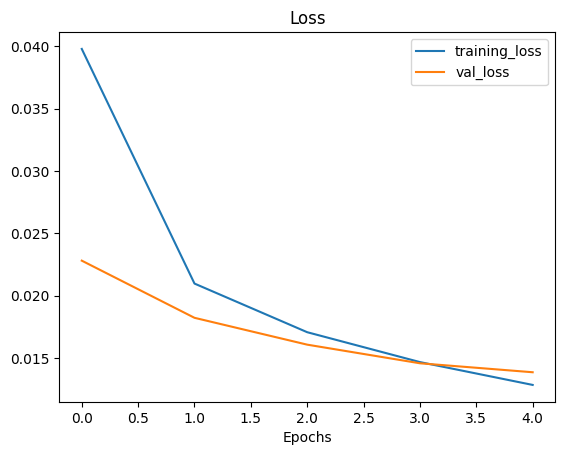

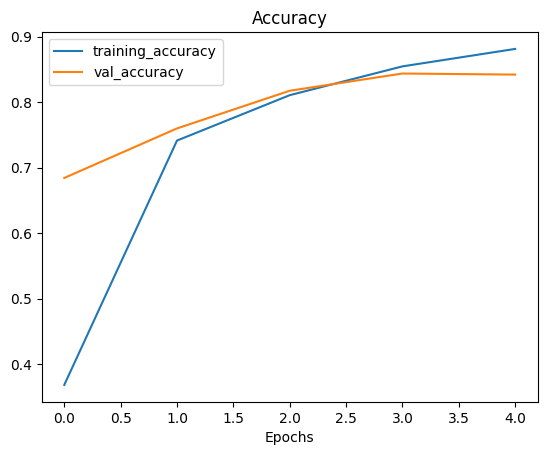

In [24]:
# Check out our model's training curves
plot_loss_curves(model_0_history)